# Logistic Regression

In [18]:
#torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

from data_loading_functions import split_train_test_loaders, show_img

# Load Dataset & Preporcessing: Logistic Regression

In [19]:
dataset_path = '.\\Combined_data'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path)

before transform
actual labels: ['Normal', 'Lung_Opacity', 'Normal', 'Normal']
numerical labels: tensor([2, 1, 2, 2])


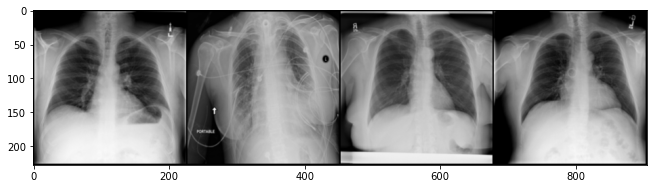

In [20]:
print('before transform')
show_img(ImageFolder(dataset_path, transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
))

train data
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
actual labels: ['Normal', 'Normal', 'Normal', 'Viral Pneumonia']
numerical labels: tensor([2, 2, 2, 3])


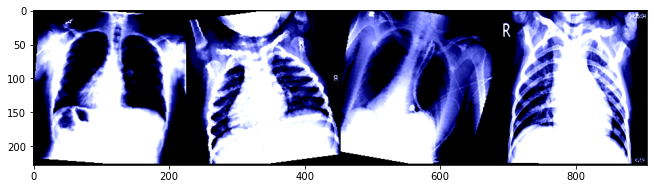

In [21]:
print('train data')
show_img(datas[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
test data
actual labels: ['COVID', 'Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity']
numerical labels: tensor([0, 1, 1, 1])


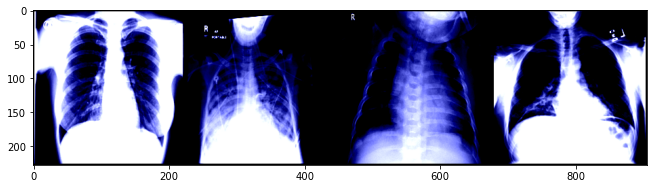

In [22]:
print('test data')
show_img(datas[2])

In [23]:
print(f'Length of Training: {len(datas[0])}')
print(f'Length of Validation: {len(datas[1])}')
print(f'Length of Testing: {len(datas[2])}')

Length of Training: 21658
Length of Validation: 2708
Length of Testing: 2707


# Model Logistic Regression

In [24]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

In [25]:
class LogisticRegression(torch.nn.Module):

    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(224*224*3, 4)
        
    def forward(self, x):
        logits = self.linear(x.view(-1, 3*224*224))
        probas = F.sigmoid(logits)
        return probas

In [26]:
torch.manual_seed(RANDOM_SEED)

model = LogisticRegression(NUM_CLASSES)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(num_epochs = NUM_EPOCHS, model = model, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/010 | Batch 0000/0339 | Loss: 1.4368
Epoch: 001/010 | Batch 0050/0339 | Loss: 1.2638
Epoch: 001/010 | Batch 0100/0339 | Loss: 1.2679
Epoch: 001/010 | Batch 0150/0339 | Loss: 1.2211
Epoch: 001/010 | Batch 0200/0339 | Loss: 1.2836
Epoch: 001/010 | Batch 0250/0339 | Loss: 1.2129
Epoch: 001/010 | Batch 0300/0339 | Loss: 1.2377
Epoch: 001/010 | Train: 53.84% | Validation: 54.10%
Time elapsed: 9.47 min
Epoch: 002/010 | Batch 0000/0339 | Loss: 1.1342
Epoch: 002/010 | Batch 0050/0339 | Loss: 1.1772
Epoch: 002/010 | Batch 0100/0339 | Loss: 1.1978
Epoch: 002/010 | Batch 0150/0339 | Loss: 1.2673
Epoch: 002/010 | Batch 0200/0339 | Loss: 1.2139
Epoch: 002/010 | Batch 0250/0339 | Loss: 1.2526
Epoch: 002/010 | Batch 0300/0339 | Loss: 1.1402
Epoch: 002/010 | Train: 59.98% | Validation: 60.16%
Time elapsed: 18.62 min
Epoch: 003/010 | Batch 0000/0339 | Loss: 1.1748
Epoch: 003/010 | Batch 0050/0339 | Loss: 1.2002
Epoch: 003/010 | Batch 0100/0339 | Loss: 1.1471
Epoch: 003/010 | Batch 0150/0339 

# Evaluation: Logistic Regression

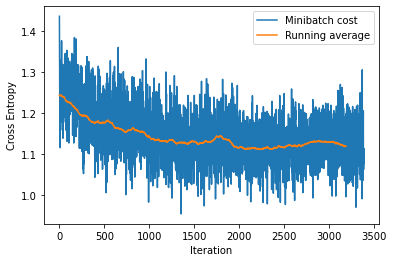

In [27]:
plt.plot(minibatch_loss_list, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

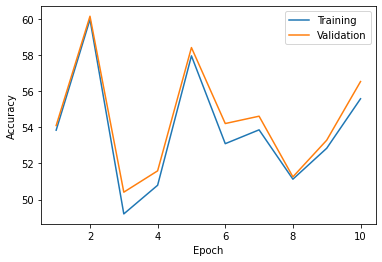

In [28]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {train_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 55.82%
Validation ACC: 56.68%
Test ACC: 55.97%
